* Yiğit Kaan Duran - 090230767
* Bican Çağrı Göksel - 090200352

# Homework: Sentiment Analysis with Yelp Review Dataset


## What is the Yelp Dataset?

This dataset is derived from Yelp reviews, where each review expresses a sentiment (1 to 5 stars) about a particular service, product, or experience. The task focuses on analyzing these reviews to extract the sentiment conveyed.





##  Motivation

Yelp is a platform where users share their experiences and opinions about various businesses, such as restaurants, stores, and services. By analyzing these reviews, we can gain insights into customer satisfaction, identify trends in consumer behavior, and understand the general perception of different businesses. This analysis can be valuable for businesses aiming to improve their services based on customer feedback.


## Problem Statement

The task is to classify each review based on its star rating, ranging from 1 to 5 stars, reflecting the sentiment expressed by the user.
This analysis will help understand the general perception of various businesses and services based on user feedback, providing valuable insights into
customer satisfaction and areas for improvement for businesses.



## What Do We Expect from You in This Assignment?

We expect you to use NLP techniques and potentially deep learning methods to analyze the text data from Yelp reviews. Your goal is to accurately classify each review based on its star rating, ranging from 1 to 5 stars.
This classification will help interpret the sentiment expressed in each review, giving insights into customer satisfaction levels across different businesses.


## Dataset Information

The Yelp dataset consists of two files:

- `yelp_review_train`: Training dataset containing labeled reviews for model training.
- `yelp_review_test`: Validation dataset for evaluating the model's performance on unseen data.

Each review is associated with a `label` ranging from 0 to 4, where:
- `label 0`: 1 star
- `label 1`: 2 stars
- `label 2`: 3 stars
- `label 3`: 4 stars
- `label 4`: 5 stars

https://huggingface.co/datasets/Yelp/yelp_review_full

The code provided below (Chapter 2) includes a step to map these labels to their corresponding star ratings for better interpretability.

## If you have any question about the homework, you can contact us at the following e-mail adresses:

*   ozgeflzcn@gmail.com
*   burcusunturlu@gmail.com



## Additional Notes

* Ensure all models and visualizations are well-commented.
* Include all explanations for key steps like tokenization, vectorization, hyperparameter tuning, model selection and performance.
* Please complete your homework using this notebook.
* We recommend using Google Colab for your project and exploring the Hugging Face platform.

## 1 - Import Libraries

Main Libraries for you to deploy your model (Feel free to use other libraries that you think helpful):

*   Pandas
*   Numpy
*   Sklearn
*   nltk
*   keras

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Machine Learning and NLP Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Input

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Preprocessing
import re
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 2 - Importing the Data (60 points)

## 2.1 - Loading the Data


*   You can easly import datasets from Hugging Face platform


In [2]:
# Load the datasets from the Hugging Face datasets library
splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet',
           'test': 'yelp_review_full/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# Create a 20% subset from the df_train DataFrame
train_df, _ = train_test_split(train_df, test_size=0.8, stratify=train_df['label'], random_state=42)

# Create a 20% subset from the df_test DataFrame
test_df, _ = train_test_split(test_df, test_size=0.8, stratify=test_df['label'], random_state=42)

# Map labels to star ratings
label_to_star = {0: '1 star', 1: '2 stars', 2: '3 stars', 3: '4 stars', 4: '5 stars'}
train_df['star_rating'] = train_df['label'].map(label_to_star)
test_df['star_rating'] = test_df['label'].map(label_to_star)

# Display the first few rows to confirm the mapping
train_df.head(10)
# test_df.head(10)

,label,text,star_rating
312157,1,"Alright, so I've been here twice. The atmosph...",2 stars
626104,2,The hotel overall is not bad. One major issue ...,3 stars
170329,2,"Been here about 15 years ago, when it was fair...",3 stars
131769,1,"This place was, eh, okay...but I probably won'...",2 stars
517274,2,This review will take the form of a note to my...,3 stars
300287,0,"Okay, so I just went to Vegas for the first ti...",1 star
565099,2,Morning Squeeze is a welcome addition to Old T...,3 stars
548911,0,This is BY FAR THE WORST POST OFFICE IN THE UN...,1 star
512724,4,IT IS A MUST EAT PLACE. The food is AMAZING an...,5 stars
269278,4,Usually quick service even with a line of cust...,5 stars


## 2.2 - Exploratory Data Analysis (EDA) (20 points)

Please investigate your data according to 'label' or 'length_category_for_eda' columns:
* Check distributions. Visualize the data distribution across length of text categories (very short to very long).
* Check null values.
* Analyze the relationship between text length and labels.
* Create word clouds for frequently used words in each category of positive, negative, and neutral reviews.(1,2 stars negative ; 3 neutral ; 4,5 positive reviews)

In [4]:
def categorize_text_length_extended(length):
    if length <= 300:
        return "very short"
    elif 301 <= length <= 600:
        return "short"
    elif 601 <= length <= 900:
        return "medium"
    elif 901 <= length <= 1200:
        return "long"
    else:
        return "very long"

# Adding a new column for text length (number of characters) and categorizing it with the extended categories
train_df['text_length'] = train_df['text'].apply(len)
train_df['length_category'] = train_df['text_length'].apply(categorize_text_length_extended)

# Adding a new column for text length (number of characters) and categorizing it with the extended categories
test_df['text_length'] = test_df['text'].apply(len)
test_df['length_category'] = test_df['text_length'].apply(categorize_text_length_extended)

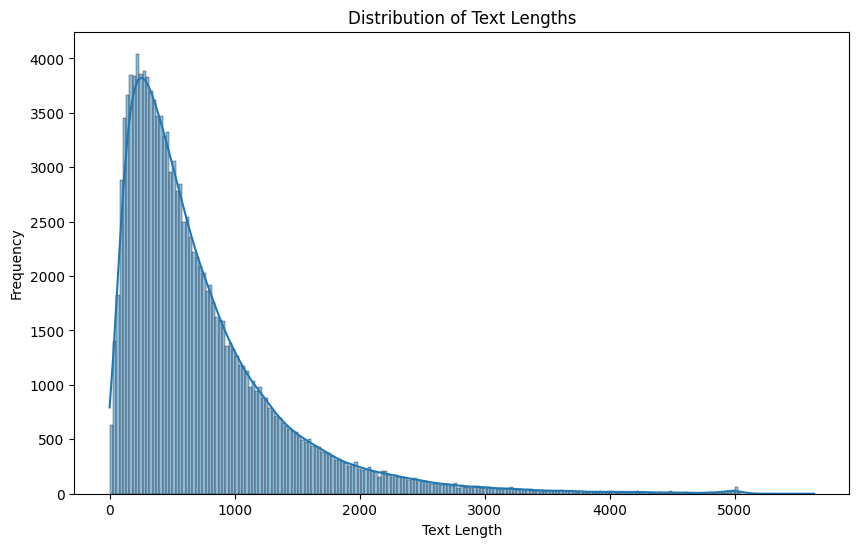

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [6]:
test_df

,label,text,star_rating,text_length,length_category
19761,0,SAGE IS NOW UNDER NEW MANAGEMENT!! Food porti...,1 star,84,very short
46153,0,Tried out this joint since I'm a real ramen lo...,1 star,683,medium
46781,4,Superb! My husband and I LOVE Glenway Premium...,5 stars,426,short
27598,2,"Eh, this market was OK, but it didn't do it fo...",3 stars,1914,very long
25156,0,OK heres the deal...I went here on a sunday ju...,1 star,475,short
...,...,...,...,...,...
11758,0,We heard a lot about this place and were excit...,1 star,630,medium
26329,0,Nice lady that seated us but it was all downhi...,1 star,839,medium
36659,1,The place may serve its purpose for some - it'...,2 stars,586,short
5302,1,"Once again, Panda has given me poor, slow serv...",2 stars,1457,very long


In [7]:
# Display basic information
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nLabel Distribution:")
print(train_df['star_rating'].value_counts(normalize=True))
print("\nText Length Categories:")
print(train_df['length_category'].value_counts(normalize=True))

Training Data Shape: (130000, 5)
Test Data Shape: (10000, 5)

Label Distribution:
star_rating
2 stars    0.2
3 stars    0.2
1 star     0.2
5 stars    0.2
4 stars    0.2
Name: proportion, dtype: float64

Text Length Categories:
length_category
short         0.283323
very short    0.264969
medium        0.177262
very long     0.169323
long          0.105123
Name: proportion, dtype: float64


<ipython-input-8-26d17fa363a7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='length_category', data=train_df, ax=axes[0], palette='pastel', order=category_order)
<ipython-input-8-26d17fa363a7>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='length_category', data=test_df, ax=axes[1], palette='pastel', order=category_order)


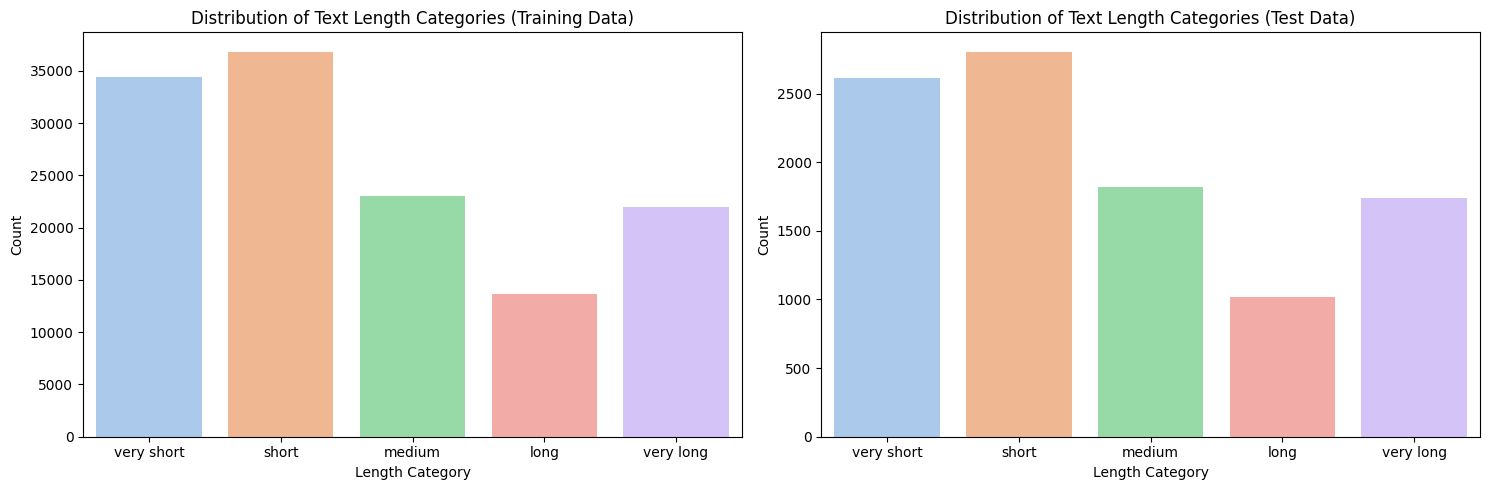

In [8]:
# creating subplots for both train and test data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# order of categories
category_order = ['very short', 'short', 'medium', 'long', 'very long']

# training data countplot
sns.countplot(x='length_category', data=train_df, ax=axes[0], palette='pastel', order=category_order)
axes[0].set_title('Distribution of Text Length Categories (Training Data)')
axes[0].set_xlabel('Length Category')
axes[0].set_ylabel('Count')

# test data countplot
sns.countplot(x='length_category', data=test_df, ax=axes[1], palette='pastel', order=category_order)
axes[1].set_title('Distribution of Text Length Categories (Test Data)')
axes[1].set_xlabel('Length Category')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

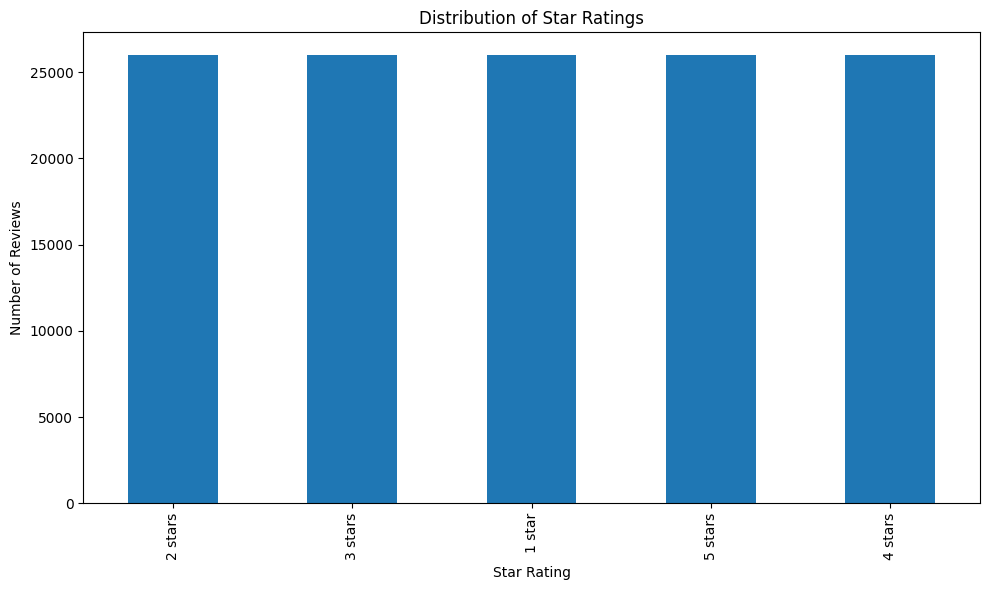

In [9]:
# Star Ratings Distribution
plt.figure(figsize=(10, 6))
train_df['star_rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

In [10]:
train_df.groupby('star_rating')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
star_rating,,,,,,,,
1 star,26000.0,816.654077,758.913389,1.0,308.0,584.0,1068.0,5115.0
2 stars,26000.0,827.458385,701.812942,1.0,347.0,632.0,1081.0,5052.0
3 stars,26000.0,758.793077,643.553026,3.0,320.0,583.5,995.0,5041.0
4 stars,26000.0,681.607615,593.594464,6.0,274.0,513.0,904.0,5637.0
5 stars,26000.0,575.225308,553.457667,2.0,219.0,407.0,736.0,5046.0


<Figure size 1200x600 with 0 Axes>

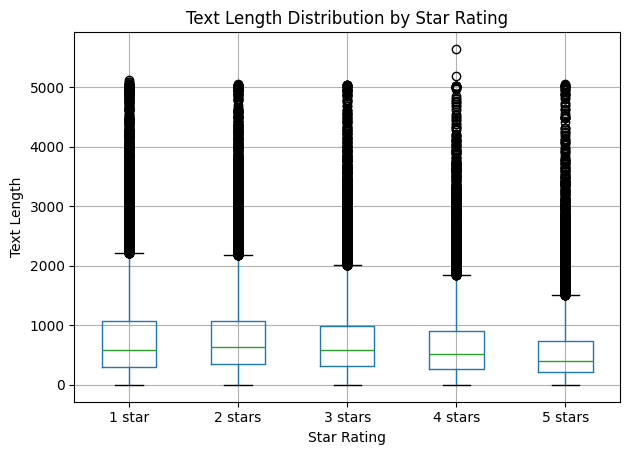

In [11]:
# Text Length Distribution by Star Rating
plt.figure(figsize=(12, 6))
train_df.boxplot(column='text_length', by='star_rating')
plt.title('Text Length Distribution by Star Rating')
plt.suptitle('')
plt.ylabel('Text Length')
plt.xlabel('Star Rating')
plt.tight_layout()
plt.show()

In [12]:
# checking null values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

label              0
text               0
star_rating        0
text_length        0
length_category    0
dtype: int64
label              0
text               0
star_rating        0
text_length        0
length_category    0
dtype: int64


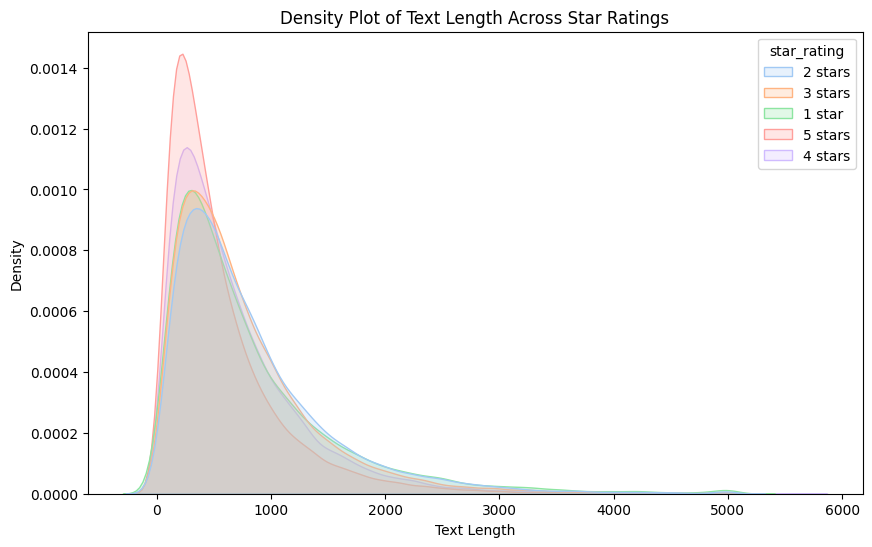

In [13]:
# density plot across rating categories
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_df, x='text_length', hue='star_rating', fill=True, common_norm=False, palette='pastel')
plt.title('Density Plot of Text Length Across Star Ratings')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.show()

In [14]:
# Word Cloud Function
def create_wordcloud(df, rating):
    text = ' '.join(df[df['star_rating'] == rating]['text'])
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=100).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {rating} Reviews')
    plt.tight_layout()
    plt.show()

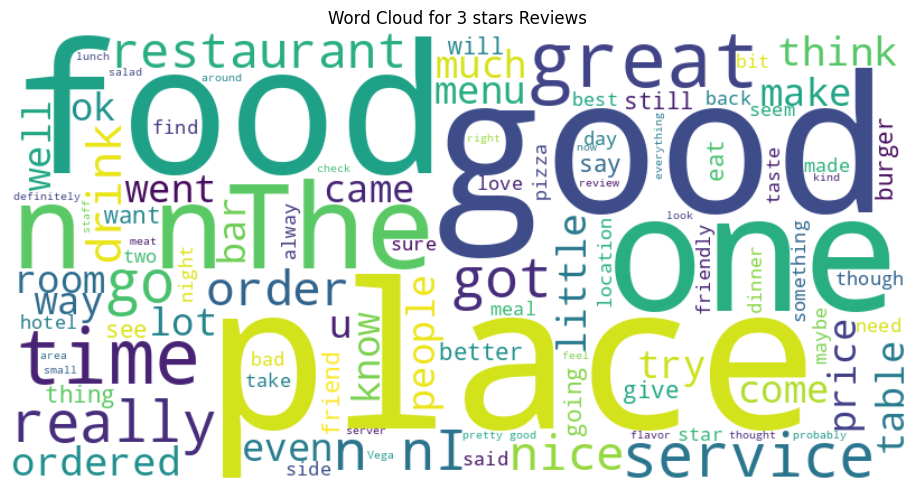

In [15]:
# Create word clouds for 3-star and 5-star reviews
create_wordcloud(train_df, '3 stars')

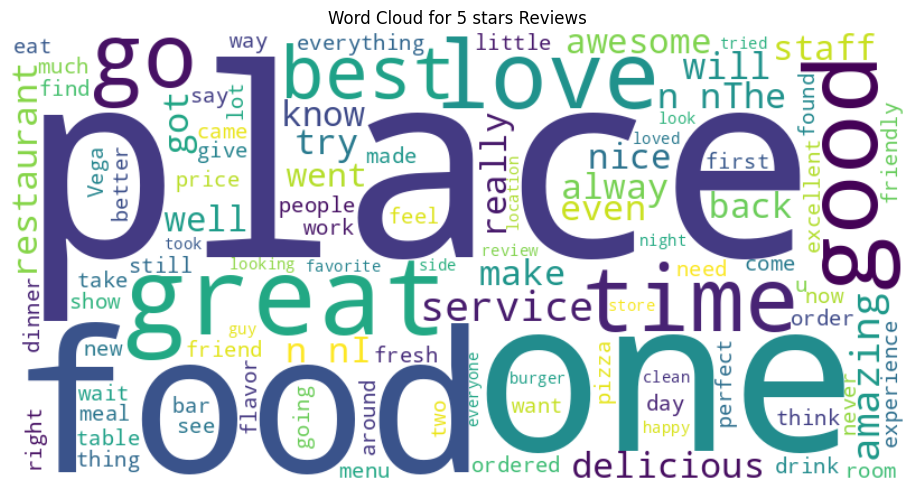

In [16]:
# Create word clouds for 3-star and 5-star reviews
create_wordcloud(train_df, '5 stars')

In [17]:
# correlation between text length and star rating
train_df['star_rating_num'] = train_df['star_rating'].str.extract('(\d+)', expand=False).astype(float)

correlation = train_df['text_length'].corr(train_df['star_rating_num'])
print(f'Correlation between text length and star rating: {correlation}')


Correlation between text length and star rating: -0.13448950576241347


In [18]:
# Null Values Check
print("\nNull Values:")
print(train_df.isnull().sum())


Null Values:
label              0
text               0
star_rating        0
text_length        0
length_category    0
star_rating_num    0
dtype: int64


## 2.3 - Data Preparation (25 points)

* Clean the comments. Remove irrelevant characters (e.g., URLs, mentions). Normalize the text (lowercasing, removing punctuation, etc.).
* Remove/unremove stopwords based on your assumption.
* Tokenize the comments.
* Lemmatize the comments.
* Vectorization.
* Word count analysis and outlier detection.

In [19]:
# Text Cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email adresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

In [20]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    # keep sentiment related stopwords
    manual_words = {'place', 'food', 'order', 'got'}
    stop_words.update(manual_words)
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

In [21]:
# Lemmatization Function
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmatized_tokens)

In [26]:
# Apply text cleaning and lemmatization
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['cleaned_text'] = train_df['cleaned_text'].apply(remove_stopwords)
train_df['processed_text'] = train_df['cleaned_text'].apply(lemmatize_text)

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(remove_stopwords)
test_df['processed_text'] = test_df['cleaned_text'].apply(lemmatize_text)

In [27]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['processed_text'])

In [28]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['processed_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

In [29]:
# Pad sequences
max_length = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [30]:
# Prepare labels
y_train = train_df['label']
y_test = test_df['label']

In [31]:
# function to analyze word counts and detect outliers
def analyze_word_counts(texts):
    # calculate word counts
    word_counts = texts.str.split().str.len()

    # statistics
    mean_count = word_counts.mean()
    std_count = word_counts.std()

    # identify outliers (using 3 std)
    outliers = word_counts[
        (word_counts < mean_count - 3*std_count) |
        (word_counts > mean_count + 3*std_count)
    ]

    print("Word Count Analysis:")
    print(f"Average words per review: {mean_count:.2f}")
    print(f"Standard deviation: {std_count:.2f}")
    print(f"Number of outliers: {len(outliers)}")

    return word_counts, outliers

Training Set Statistics:
Word Count Analysis:
Average words per review: 66.52
Standard deviation: 59.65
Number of outliers: 2544

Test Set Statistics:
Word Count Analysis:
Average words per review: 66.61
Standard deviation: 59.09
Number of outliers: 186


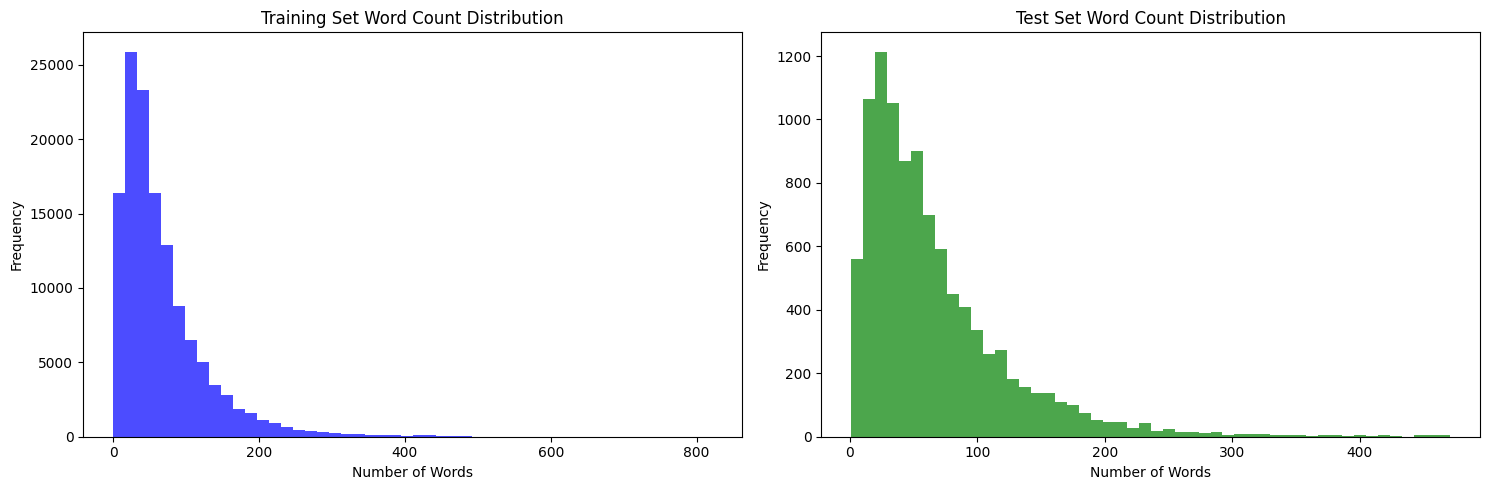


Sample of original vs processed text (Training Set):

Training Original: Alright, so I've been here twice.  The atmosphere is ok, seating is a little awkward and the lightin...
Training Processed: alright ive twice atmosphere ok seating little awkward lighting could better service decent decent e...

Training Original: The hotel overall is not bad. One major issue is that the hotel doesn't filter the cigarette smoke s...
Training Processed: hotel overall bad one major issue hotel doesnt filter cigarette smoke smell everywhere valet check u...

Sample of original vs processed text (Test Set):

Test Original: SAGE IS  NOW UNDER NEW MANAGEMENT!! Food portions are small and prices have gone up!...
Test Processed: sage new management portion small price gone...

Test Original: Tried out this joint since I'm a real ramen lover. This ramen place is definitely one of the bad one...
Test Processed: tried joint since im real ramen lover ramen definitely one bad one town ive eaten lot ramen hous

In [32]:
# analyze training set
print("Training Set Statistics:")
train_word_counts, train_outliers = analyze_word_counts(train_df['processed_text'])

# analyze test set
print("\nTest Set Statistics:")
test_word_counts, test_outliers = analyze_word_counts(test_df['processed_text'])

# create subplots
plt.figure(figsize=(15, 5))
# for training
plt.subplot(1, 2, 1)
plt.hist(train_word_counts, bins=50, color='blue', alpha=0.7)
plt.title('Training Set Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# for training
plt.subplot(1, 2, 2)
plt.hist(test_word_counts, bins=50, color='green', alpha=0.7)
plt.title('Test Set Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# show samples from each dataset
print("\nSample of original vs processed text (Training Set):")
for i in range(2):
    print(f"\nTraining Original: {train_df['text'].iloc[i][:100]}...")
    print(f"Training Processed: {train_df['processed_text'].iloc[i][:100]}...")

print("\nSample of original vs processed text (Test Set):")
for i in range(2):
    print(f"\nTest Original: {test_df['text'].iloc[i][:100]}...")
    print(f"Test Processed: {test_df['processed_text'].iloc[i][:100]}...")

# comparison between training and test
print("\nComparison of Training vs Test Statistics:")
print(f"Training Mean Words: {train_word_counts.mean():.2f}")
print(f"Test Mean Words: {test_word_counts.mean():.2f}")
print(f"Training Outliers: {len(train_outliers)} ({(len(train_outliers)/len(train_word_counts)*100):.2f}%)")
print(f"Test Outliers: {len(test_outliers)} ({(len(test_outliers)/len(test_word_counts)*100):.2f}%)")

## 2.4 - TF(Term Frequency) - IDF(Inverse Document Frequency) (15 points)

* Explain TF & IDF.
* Apply TF & IDF methods.

In [33]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])

In [34]:
print("Training data shape after preprocessing:", X_train_padded.shape)
print("TF-IDF matrix shape:", X_train_tfidf.shape)

Training data shape after preprocessing: (130000, 200)
TF-IDF matrix shape: (130000, 10000)


# 3 - Training Deep Learning Models (30 Points)

* Import relevant libraries.
* Explain the differences between Neural Networks (NN), Convolutional Neural Networks (CNN), and Recurrent Neural Networks (RNN).

* **NN** : These are the simplest form of neural networks, consisting of layers of interconnected neurons that process and transmit information.
* Structure:
  - Input Layer: Receives input data.
  - Hidden Layers: Intermediate layers that transform the input data.
  - Output Layer: Produces the final prediction or classification.

* **CNN** : These are specialized neural networks designed for processing structured grid data like images. They use convolutional layers to detect features.
* Structure:
  - Convolutional Layers: Apply filters to the input data to create feature maps.
  - Pooling Layers: Reduce the dimensionality of feature maps.
  - Fully Connected Layers: Connect neurons from previous layers to the output layer.

* **RNN**: These are designed for sequential data, where each neuron connects to the next layer and to neurons within the same layer.
* Structure:
  - Recurrent Connections: Neurons have connections looping back to themselves, allowing information to persist.
  - Hidden State: Maintains a memory of previous inputs.

* **Key Differences Between NN, CNN, RNN**
* Data Type:
 - NN: General-purpose, works with a variety of data types.
 - CNN: Best suited for spatial data (e.g., images).
 - RNN: Designed for sequential data (e.g., time series, text).

* Architecture Complexity:
 - NN: Simple, fully connected layers.
 - CNN: Convolutional and pooling layers, followed by fully connected layers.
 - RNN: Recurrent connections, simple architecture.

* Learning Capabilities:
 - NN: Limited in handling complex data structures.
 - CNN: Excels at detecting spatial hierarchies.
 - RNN: Good for short-term dependencies.

* Training Challenges:
 - NN: Overfitting and underfitting issues.
 - CNN: High computational requirements.
 - RNN: Vanishing gradient problem.

## 3.1 - Training NN Model

* Construct models starting from a simple neural network (NN) with a single layer, and incrementally add layers to build more complex architectures. Analyze the performance differences among them.
* Experiment with different activation functions, optimizers, and regularization techniques (such as dropout rates). For each trial, document the effects of these changes. For example, observe how adding or removing layers, changing activation functions, or adjusting dropout rates impacts performance.
* Tune hyperparameters like learning rate, number of layers, and dropout percentage. Explain how each adjustment affects overfitting, underfitting, and generalization on the test data.

# Observations
* First model with a Embedding + Flatten and Output layer overfits.
* Adding one hidden layer (64) increased the accuracy but still overfits.
* Added early_stopping. Stops training on epoch 7 with training loss:0.5507, acc:0.7873 and val_acc:0.4991, val_loss:1.5218. Still overfits.
* Dropout(0.5) decreased the val_loss and  but increased the train_loss.
* Lower dropout increased acc but increased val_loss.
* Hiddenlayer 64->128 val_loss increased from start.
* Added another hiddenlayer with 64 and dropout(0.5). Still overfits.
* Decreased first hidden layer unit to 64 to reduce model complexity. Still overfits, while val_loss is increasing starting from epoch3.
* added Adam(learning_rate=0.0005).
* LeakyRelu doesnt make any meaningful impact.
* l2 regularizaton with 0.01 and 0.005 tested. overfit delayed a little but accuracy decreased.
* Replaced Flatten to GlobalMaxPooling1d to reduce dimensionality
* Removed l2 regularization to boost training accuracy
* Added 2 dropout layers to avoid overfitting as possible
* Reduced hidden layer units to reduce the complexity of model

In [35]:
# Simple Neural Network Model
def create_simple_nn(input_shape, num_classes):
    model = Sequential([
        Embedding(10000, 32, input_length=input_shape[1]),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [36]:
# Convolutional Neural Network Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Embedding(10000, 64, input_length=input_shape[1]),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [37]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [38]:
# Train Simple Neural Network
simple_nn = create_simple_nn(X_train_padded.shape, 5)
history_simple_nn = simple_nn.fit(
    X_train_padded, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=128,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3470 - loss: 1.4135 - val_accuracy: 0.5250 - val_loss: 1.0883
Epoch 2/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5173 - loss: 1.1132 - val_accuracy: 0.5337 - val_loss: 1.0639
Epoch 3/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5374 - loss: 1.0713 - val_accuracy: 0.5370 - val_loss: 1.0572
Epoch 4/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5485 - loss: 1.0496 - val_accuracy: 0.5351 - val_loss: 1.0576
Epoch 5/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5557 - loss: 1.0342 - val_accuracy: 0.5383 - val_loss: 1.0598
Epoch 6/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5593 - loss: 1.0183 - val_accuracy: 0.5387 - val_loss: 1.0616
Epoch 7/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5673 - loss: 1.0099 - val_accuracy: 0.5406 - val_loss: 1.0655
Epoch 8/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5709 - loss: 0.9966 - val_accuracy: 0

In [39]:
# Train CNN Model
cnn_model = create_cnn_model(X_train_padded.shape, 5)
history_cnn = cnn_model.fit(
    X_train_padded, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.3517 - loss: 1.4025 - val_accuracy: 0.5457 - val_loss: 1.0480
Epoch 2/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5421 - loss: 1.0575 - val_accuracy: 0.5505 - val_loss: 1.0256
Epoch 3/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5792 - loss: 0.9756 - val_accuracy: 0.5587 - val_loss: 1.0138
Epoch 4/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6081 - loss: 0.9082 - val_accuracy: 0.5550 - val_loss: 1.0291
Epoch 5/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6344 - loss: 0.8464 - val_accuracy: 0.5471 - val_loss: 1.0570
Epoch 6/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6632 - loss: 0.7877 - val_accuracy: 0.5415 - val_loss: 1.1433
Epoch 7/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6888 - loss: 0.7311 - val_accuracy: 0.5398 - val_loss: 1.1870
Epoch 8/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7153 - loss: 0.6771 - val_accuracy: 

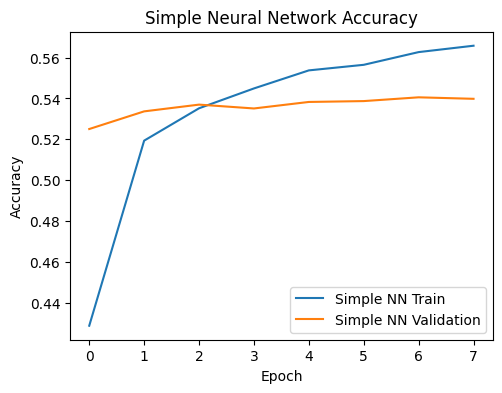

In [40]:
#Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_simple_nn.history['accuracy'], label='Simple NN Train')
plt.plot(history_simple_nn.history['val_accuracy'], label='Simple NN Validation')
plt.title('Simple Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

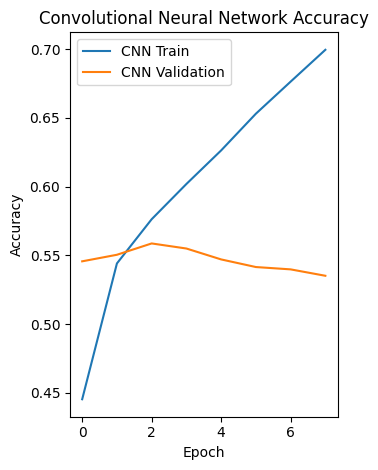

In [41]:
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Train')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation')
plt.title('Convolutional Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 4 - Model Evaluation on the Validation Set (10 points)

* Evaluate the best model's performance on the validation set using a Confusion Matrix along with metrics such as accuracy, precision, recall, and F1-score. How well does the model generalize to new data based on these metrics?



In [42]:
# Evaluate Models
def evaluate_model(model, X_test, y_test):
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Classification Report
    print(classification_report(y_test, y_pred_classes,
                                target_names=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
                yticklabels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

Simple Neural Network Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

      1 Star       0.63      0.77      0.69      2000
     2 Stars       0.48      0.40      0.44      2000
     3 Stars       0.45      0.44      0.44      2000
     4 Stars       0.47      0.42      0.44      2000
     5 Stars       0.62      0.66      0.64      2000

    accuracy                           0.54     10000
   macro avg       0.53      0.54      0.53     10000
weighted avg       0.53      0.54      0.53     10000



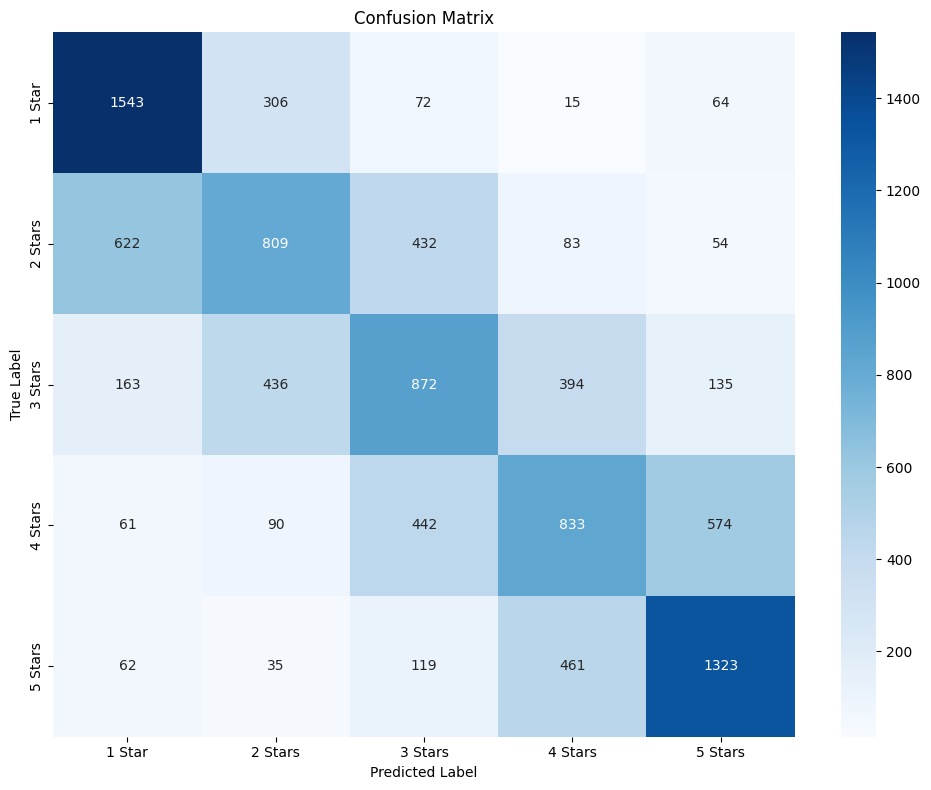

In [43]:
# Evaluate Simple NN
print("Simple Neural Network Evaluation:")
evaluate_model(simple_nn, X_test_padded, y_test)

* We can see that the low-mid accuracy of the model is caused by the number of classes.
* Model is generalized well if we redefine sentiments as positive-negative-neutral.


Convolutional Neural Network Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

      1 Star       0.66      0.78      0.72      2000
     2 Stars       0.49      0.49      0.49      2000
     3 Stars       0.47      0.35      0.40      2000
     4 Stars       0.46      0.49      0.48      2000
     5 Stars       0.64      0.66      0.65      2000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



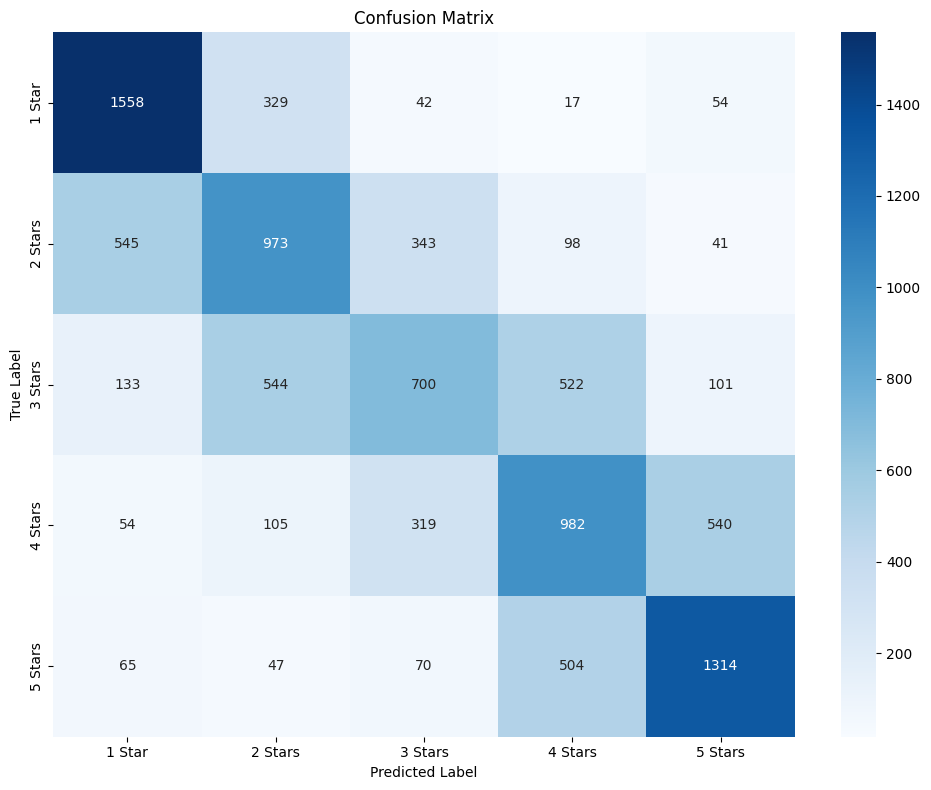

In [44]:
# Evaluate CNN
print("\nConvolutional Neural Network Evaluation:")
evaluate_model(cnn_model, X_test_padded, y_test)

## 4.1 - Testing with your Own Input

* You can test the trained model by inputting your own sentences to predict the sentiment:


In [45]:
# Prediction Function
def predict_sentiment(text, model, tokenizer, max_length):
    # Clean and preprocess the text
    cleaned_text = clean_text(text)
    lemmatized_text = lemmatize_text(cleaned_text)

    # Convert text to sequence
    text_seq = tokenizer.texts_to_sequences([lemmatized_text])
    text_padded = pad_sequences(text_seq, maxlen=max_length, padding='post', truncating='post')

    # Predict
    prediction = model.predict(text_padded)
    predicted_class = np.argmax(prediction)

    # Map to star rating
    star_ratings = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
    return star_ratings[predicted_class]

In [46]:
# Example predictions
test_sentences = [
    'The food and ambiance at this restaurant were fantastic!',
    "Terrible experience, would not recommend.",
    "An average meal with nothing special.",
    "There is ups and downs about the place. Not the best but not the worst neither. But the presentation was nice to be honest."
]

In [47]:
for sentence in test_sentences:
    print(f"Sentence: {sentence}")
    print(f"Predicted sentiment (Simple NN): {predict_sentiment(sentence, simple_nn, tokenizer, max_length)}")
    print(f"Predicted sentiment (CNN): {predict_sentiment(sentence, cnn_model, tokenizer, max_length)}\n")

Sentence: The food and ambiance at this restaurant were fantastic!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted sentiment (Simple NN): 5 stars
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Predicted sentiment (CNN): 5 stars

Sentence: Terrible experience, would not recommend.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted sentiment (Simple NN): 1 star
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted sentiment (CNN): 1 star

Sentence: An average meal with nothing special.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted sentiment (Simple NN): 3 stars
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted sentiment (CNN): 2 stars

Sentence: There is ups and downs about the place. Not the best but not the worst neither. But the presentation was nice to be honest.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted sentiment (Simple NN): 5 stars
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted sentiment (CNN): 1 star



# 5 - Bonus - Adding Transformer Layer to the NN Model (15 points)

* How can a transformer layer be added to the NN model created in Chapter 3. Research and implement a solution to add a transformer layer to the neural network model. Document your findings, including how the transformer layer integrates with the existing architecture, its impact on model performance, and any adjustments required. Explain your approach and reasoning based on your research.

In [48]:
# Import additional required layers
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Input

def create_transformer_nn(input_shape, num_classes, head_size=256, num_heads=4):
    """
    Create a neural network with transformer layers

    Args:
        input_shape: Shape of input data
        num_classes: Number of output classes
        head_size: Size of attention heads
        num_heads: Number of attention heads
    """
    inputs = Input(shape=(input_shape[1],))

    # Embedding layer
    x = Embedding(10000, 64, input_length=input_shape[1])(inputs)

    # Transformer block
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=head_size // num_heads
    )(x, x)

    # Add & Normalize
    x = LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed Forward Network
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)

    # Global pooling
    x = GlobalMaxPooling1D()(x)

    # Final layers
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [49]:
# Create and train the transformer model
transformer_model = create_transformer_nn(X_train_padded.shape, 5)
history_transformer = transformer_model.fit(
    X_train_padded, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=128,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.3617 - loss: 1.4411 - val_accuracy: 0.5078 - val_loss: 1.1169
Epoch 2/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.5062 - loss: 1.1280 - val_accuracy: 0.5438 - val_loss: 1.0467
Epoch 3/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5390 - loss: 1.0646 - val_accuracy: 0.5532 - val_loss: 1.0221
Epoch 4/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5528 - loss: 1.0317 - val_accuracy: 0.5543 - val_loss: 1.0218
Epoch 5/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.5633 - loss: 1.0103 - val_accuracy: 0.5639 - val_loss: 1.0125
Epoch 6/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5649 - loss: 1.0014 - val_accuracy: 0.5514 - val_loss: 1.0347
Epoch 7/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.5693 - loss: 0.9915 - val_accuracy: 0.5602 - val_loss: 1.0234
Epoch 8/20
813/813 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5736 - loss: 0.9750 - 


Transformer Model Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

      1 Star       0.70      0.72      0.71      2000
     2 Stars       0.47      0.53      0.50      2000
     3 Stars       0.51      0.39      0.44      2000
     4 Stars       0.47      0.49      0.48      2000
     5 Stars       0.65      0.67      0.66      2000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



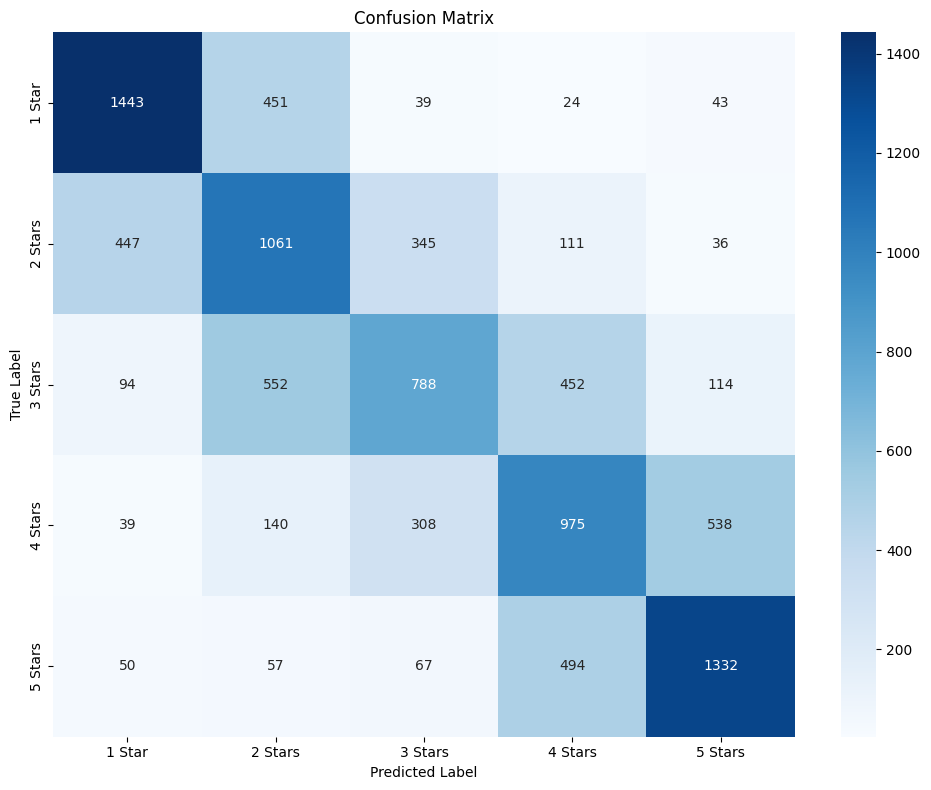

In [50]:
# Evaluate the transformer model
print("\nTransformer Model Evaluation:")
evaluate_model(transformer_model, X_test_padded, y_test)

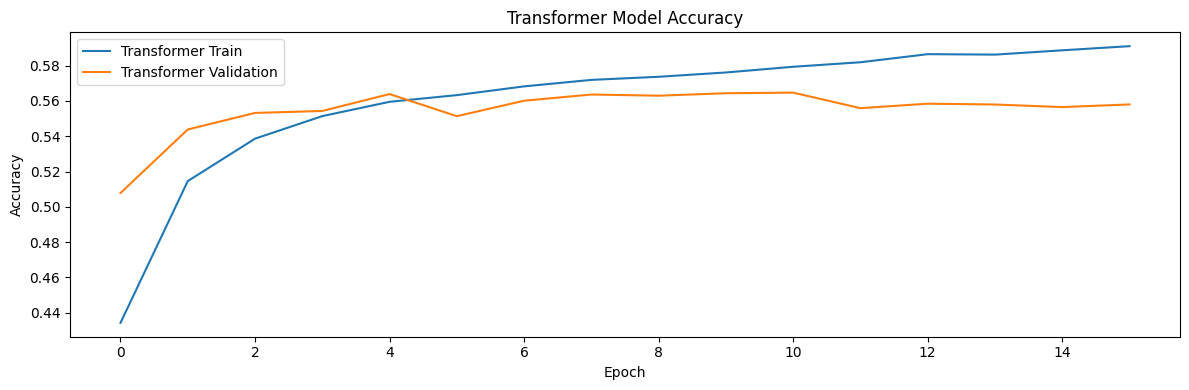

In [51]:
# Plot training history including transformer model
plt.figure(figsize=(12, 4))
plt.plot(history_transformer.history['accuracy'], label='Transformer Train')
plt.plot(history_transformer.history['val_accuracy'], label='Transformer Validation')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()